This notebook uses a `SuperTimeDependentSystem` to evaluate the dynamics of several systems with different detunings in the absence of a field.

In [1]:
import sys
sys.path.insert(0,'..')

import oqupy
import numpy as np
import matplotlib.pyplot as plt
from oqupy import contractions

In [2]:
oqupy.__version__

'0.3.1'

In [3]:
sigma_x = oqupy.operators.sigma("x")
sigma_y = oqupy.operators.sigma("y")
sigma_z = oqupy.operators.sigma("z")
up_density_matrix = oqupy.operators.spin_dm("z+")
down_density_matrix = oqupy.operators.spin_dm("z-")
mixed_density_matrix = oqupy.operators.spin_dm("mixed")

In [4]:
omega_cutoff = 3.04
alpha = 0.126
temperature = 0.1309
initial_state=down_density_matrix

In [5]:
def gaussian_shape(t, area = 1.0, tau = 1.0, t_0 = 0.0):
    return area/(tau*np.sqrt(np.pi)) * np.exp(-(t-t_0)**2/(tau**2))

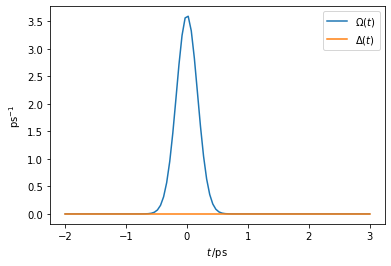

In [6]:
detuning = lambda t: 0.0 * t

t = np.linspace(-2,3,100)
Omega_t = gaussian_shape(t, area = np.pi/2.0, tau = 0.245)
Delta_t = detuning(t)

plt.plot(t, Omega_t,label=r"$\Omega(t)$")
plt.plot(t, Delta_t,label=r"$\Delta(t)$")
plt.xlabel(r"$t\,/\mathrm{ps}$")
plt.ylabel(r"$\mathrm{ps}^{-1}$")
plt.legend()

In [7]:
# define hamiltonian and initailize system
def hamiltonian_t(t):
    return detuning(t)/2.0 * sigma_z \
           + gaussian_shape(t, area = np.pi/2.0, tau = 0.245)/2.0 * sigma_x

system = oqupy.TimeDependentSystem(hamiltonian_t)

In [8]:
# define process tensor
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(sigma_z/2.0, correlations)

tempo_parameters = oqupy.TempoParameters(dt=0.1, dkmax=20, epsrel=10**(-4))

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=-2.0,
                                        end_time=3.0,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 1.0s


In [9]:
deltas = [-10.0, -5.0, 0.0, 5.0, 10.0]
systems = []
for delta in deltas:
    # NOTE: omitting "delta=delta" in the parameter definition below
    #       would lead to all systems having the same detuning.
    #       This is a common python pitfall. Check out
    #       https://docs.python-guide.org/writing/gotchas/#late-binding-closures
    #       for more information on this.
    def hamiltonian_t(t, delta=delta):
        return delta/2.0 * sigma_z \
            + gaussian_shape(t, area = np.pi/2.0, tau = 0.245)/2.0 * sigma_x
    system = oqupy.TimeDependentSystem(hamiltonian_t)
    systems.append(system)

In [10]:
super_system = oqupy.SuperTimeDependentSystem(systems)
initial_state_list = [initial_state for system in super_system.system_list]
super_system_dynamics = contractions.compute_dynamics_multiple_systems(super_system, initial_state_list=initial_state_list, 
                                                                                        start_time=-2.0,
                                                                                        process_tensor_list = process_tensor
                                                                                        )

--> Compute dynamics:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.5s


In [11]:
s_xy_list = []
t_list = []

for dynamics in super_system_dynamics.dynamics_list:
    t, s_x = dynamics.expectations(sigma_x, real=True)
    _, s_y = dynamics.expectations(sigma_y, real=True)
    s_xy = np.sqrt(s_x**2 + s_y**2)
    s_xy_list.append(s_xy)
    t_list.append(t)

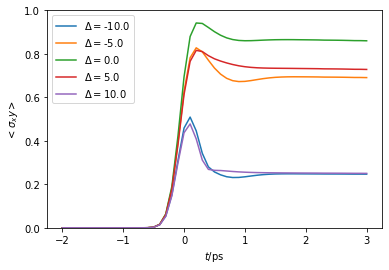

In [12]:
for t, s_xy, delta in zip(t_list, s_xy_list, deltas):
    plt.plot(t, s_xy, label=r"$\Delta = $"+f"{delta:0.1f}")
    plt.xlabel(r'$t/$ps')
    plt.ylabel(r'$<\sigma_xy>$')
plt.ylim((0.0,1.0))
plt.legend()